<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/GraphNeuralNetworkPlayground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric
!pip install  networkx
!pip install ipdb

^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/home/ec2-user/virtenv/bin/python3 -m pip install --upgrade pip' command.
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/home/ec2-user/virtenv/bin/python3 -m pip install --upgrade pip' command.
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/home/ec2-user/virtenv/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from ipdb import set_trace as st
from torch import nn

# ITER - 1

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [ ]:
dataset.__dict__

{'name': 'Cora',
 'split': 'public',
 'root': '/tmp/Cora',
 'transform': None,
 'pre_transform': None,
 'pre_filter': None,
 'log': True,
 '_indices': None,
 '_data': Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708]),
 'slices': None,
 '_data_list': None}

In [ ]:
dataset.num_node_features, dataset.num_edge_features

(1433, 0)

In [ ]:
dataset._data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
edges = dataset.data.edge_index

In [ ]:
edges.shape

torch.Size([2, 10556])

In [ ]:
edges = dataset.data.edge_index.numpy()

In [ ]:
np.min(edges[0] == edges[0, :]), np.min(edges[1] == edges[1, :])

(True, True)

In [ ]:
edge_list = [(x, y) for x, y in zip(edges[0], edges[1])]

In [ ]:
edge_list

In [ ]:
nodes = [i for i in range(np.max(edge_list))]

In [ ]:
graph = nx.Graph()

In [ ]:
graph.add_nodes_from(nodes)
graph.add_edges_from(edge_list)


In [ ]:
labels = dataset.data.y

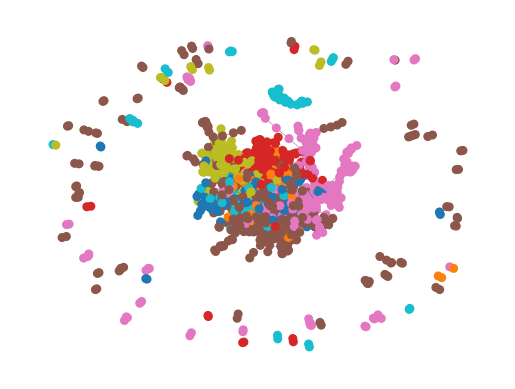

In [ ]:
plt.subplot(111)
options = {
            'node_size': 30,
            'width': 0.2,
}
nx.draw(graph, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
plt.show()


In [ ]:
def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()
# plot_dataset(dataset)

In [ ]:
# 2 classes - Single Layer Class and a Neural Network class that has multiple layers
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops

        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.

        return x_j


In [ ]:
class Net(nn.Module):
  def __init__(self, dataset):
    super(Net, self).__init__()
    self.c1 = GCNConv(dataset.num_node_features, 24)
    self.bn = nn.BatchNorm1d(24)
    self.c2 = GCNConv(24, dataset.num_classes)
    self.bn_2 = nn.BatchNorm1d(dataset.num_classes)
  
  def forward(self, dataset):
    x, edge_index = dataset.data.x, dataset.data.edge_index

    h1 = F.relu(self.bn(self.c1(x, edge_index)))
    h1 = F.dropout(h1, p = 0.5, training = self.training)
    h2 = F.dropout(self.bn_2(self.c2(h1, edge_index)), p = 0.5, training = self.training)
    return F.log_softmax(h2, dim = 1)


In [ ]:
layer = GCNConv(dataset.num_node_features, 24)

In [ ]:
x, edge_index = dataset.x, dataset.edge_index

In [ ]:
yhat = layer(x, edge_index)

In [ ]:
yhat.shape

torch.Size([2708, 100])

In [ ]:
model = Net(dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)

def test(data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))

def train(data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            train_acc = test(data)
            test_acc = test(data, train=False)

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()

In [ ]:
train(dataset, plot = True)

# ITER - 2

In [ ]:
'''
2 functions 
1. update function - gaama
2. message function - fi

Spec: 
What aggregation sceheme to use. weather its mean, add or max?
Edge Conv: Xik = sum(mlp(XiK-1 , (XiK-1) - (XjK-1)))
'''

In [ ]:
class EdgeConv(MessagePassing):
  def __init__(self, in_channels, out_channels):
    super(EdgeConv, self).__init__(aggr = 'add')
    self.mlp = nn.Sequential(nn.Linear(in_channels*2, out_channels),
                             nn.BatchNorm1d(out_channels),
                             nn.ReLU(), 
                             nn.Linear(out_channels, out_channels),
                             nn.BatchNorm1d(out_channels))
    
  def forward(self, x, edge_index):
    return self.propagate(edge_index, x = x)
  
  def message(self, x_i, x_j):
    inp = torch.cat([x_i, (x_j - x_i)], dim = 1)
    return self.mlp(inp)

In [ ]:
a = torch.randn(1, 10)
b = torch.randn(1, 10)
c = torch.cat([a, b], dim = 1)

c.shape

torch.Size([1, 20])

In [ ]:
edge_conv = EdgeConv(dataset.num_node_features, 128)

In [ ]:
class EdgeNet(nn.Module):
  def __init__(self, dataset):
    super(EdgeNet, self).__init__()
    self.c1 = EdgeConv(dataset.num_node_features, 128)
    self.c2 = GCNConv(128, dataset.num_classes)
  
  def forward(self, dataset):
    x, edge_index = dataset.data.x, dataset.data.edge_index

    h1 = self.c1(x, edge_index)
    h1 = F.dropout(h1, p = 0.5, training = self.training)
    h2 = F.dropout(self.c2(h1, edge_index), p = 0.5, training = self.training)
    return F.log_softmax(h2, dim = 1)

In [ ]:
model = EdgeNet(dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch: 000, Loss: 58.05602, Train Acc: 0.49286, Test Acc: 0.34900
Epoch: 001, Loss: 43.36913, Train Acc: 0.52857, Test Acc: 0.31500
Epoch: 002, Loss: 50.69139, Train Acc: 0.57143, Test Acc: 0.31200
Epoch: 003, Loss: 41.02229, Train Acc: 0.61429, Test Acc: 0.36400
Epoch: 004, Loss: 29.34721, Train Acc: 0.65000, Test Acc: 0.39400
Epoch: 005, Loss: 20.61322, Train Acc: 0.63571, Test Acc: 0.40500
Epoch: 006, Loss: 7.98051, Train Acc: 0.65714, Test Acc: 0.39000
Epoch: 007, Loss: 17.08380, Train Acc: 0.64286, Test Acc: 0.41900
Epoch: 008, Loss: 49.49514, Train Acc: 0.65714, Test Acc: 0.39700
Epoch: 009, Loss: 26.77965, Train Acc: 0.68571, Test Acc: 0.38900
Epoch: 010, Loss: 21.99355, Train Acc: 0.65000, Test Acc: 0.38700
Epoch: 011, Loss: 21.39690, Train Acc: 0.58571, Test Acc: 0.38400
Epoch: 012, Loss: 36.78561, Train Acc: 0.55714, Test Acc: 0.38500
Epoch: 013, Loss: 70.36671, Train Acc: 0.58571, Test Acc: 0.39300
Epoch: 014, Loss: 34.05000, Train Acc: 0.61429, Test Acc: 0.41400
Epoch: 015,

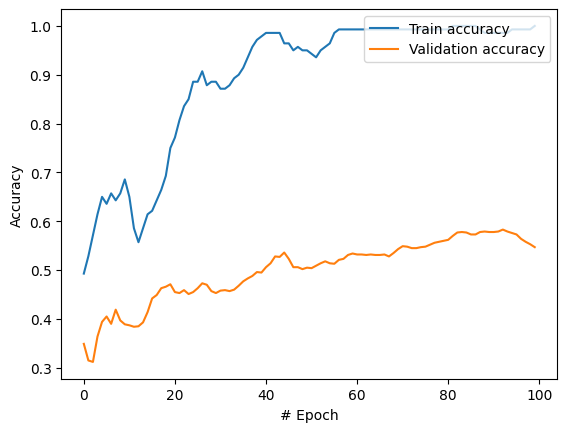

In [ ]:
train(dataset, plot = True)

# Graph Classification

In [64]:
import torch
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

NameError: ignored

In [ ]:
dataset[0]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

In [ ]:
data = dataset[0]

In [30]:
def plot_graph(data):
    edges_raw = data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False,  cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()
# plot_dataset(dataset)

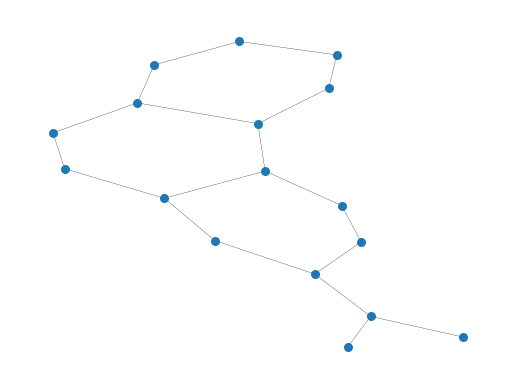

In [ ]:
plot_graph(data)

In [ ]:
data.edge_index

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])

In [ ]:
batch = next(iter(train_loader))

In [ ]:
batch

DataBatch(edge_index=[2, 712], x=[321, 7], edge_attr=[712, 4], y=[16], batch=[321], ptr=[17])

In [ ]:
batch.batch

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 

In [ ]:
batch.edge_index

tensor([[  0,   0,   1,  ..., 318, 319, 320],
        [  1,   5,   0,  ..., 320, 318, 318]])

In [31]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [32]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.sigmoid(self.lin(x))
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6667, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 007, Train Acc: 0.7333, Test Acc: 0.7632
Epoch: 008, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 009, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 010, Train Acc: 0.7200, Test Acc: 0.8421
Epoch: 011, Train Acc: 0.7000, Test Acc: 0.7895
Epoch: 012, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 013, Train Acc: 0.7533, Test Acc: 0.7632
Epoch: 014, Train Acc: 0.7333, Test Acc: 0.7895
Epoch: 015, Train Acc: 0.7600, Test Acc: 0.7368
Epoch: 016, Train Acc: 0.7600, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.6733, Test Acc: 0.7368
Epoch: 018, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 019, Train Acc: 0.7600, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.7667, Test Acc: 0.7368
Epoch: 021, Train Acc: 0.7533, Test Acc:

In [ ]:
from typing import Tuple, Union

from torch import Tensor

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
)
from torch_geometric.utils import spmm


class GraphConv(MessagePassing):
    
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        aggr: str = 'add',
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_rel = Linear(in_channels[0], out_channels, bias=bias)
        self.lin_root = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_rel.reset_parameters()
        self.lin_root.reset_parameters()

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_weight: OptTensor = None, size: Size = None) -> Tensor:

        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # propagate_type: (x: OptPairTensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight, size=size)
        out = self.lin_rel(out)

        x_r = x[1]
        if x_r is not None:
            out = out + self.lin_root(x_r)

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        st()
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: OptPairTensor) -> Tensor:
        return spmm(adj_t, x[0], reduce=self.aggr)

In [ ]:
gc = GraphConv(dataset.num_node_features, 32)

In [ ]:
batch

DataBatch(edge_index=[2, 712], x=[321, 7], edge_attr=[712, 4], y=[16], batch=[321], ptr=[17])

In [ ]:
gc(batch.x, batch.edge_index)

> <ipython-input-35-64f3b2e98466>(63)message()
     62         st()
---> 63         return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j
     64 

ipdb> ll
     61     def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
     62         st()
---> 63         return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j
     64 

ipdb> x_j
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
ipdb> x_j.shape
torch.Size([712, 7])
ipdb> exit


# Graph Attention

In [3]:
import torch.nn.init as init
from torch_geometric.utils import softmax
from torch_geometric.nn import global_mean_pool
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [4]:
batch = next(iter(train_loader))

In [5]:
batch.x, batch.edge_index

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]]),
 tensor([[  0,   0,   1,  ..., 318, 319, 320],
         [  1,   5,   0,  ..., 320, 318, 318]]))

In [ ]:
batch.x.shape

torch.Size([321, 7])

In [ ]:
dataset.num_node_features

7

In [6]:
def linear_layer(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), 
                      nn.LazyBatchNorm1d(out_channels),
                      nn.ReLU())
  
class MyGatConv(MessagePassing):
  def __init__(self, in_channels, out_channels):
    super(MyGatConv, self).__init__(aggr = 'add')
    self.w = linear_layer(in_channels, out_channels)
    self.in_c = in_channels
    self.out_c = out_channels
    self.leaky_r = nn.LeakyReLU(negative_slope=0.2)
    self.attn = nn.Parameter(torch.Tensor(out_channels*2, 1))
    init.kaiming_normal_(self.w[0].weight, nonlinearity='relu')
    init.kaiming_normal_(self.attn, nonlinearity='relu')
    
  def forward(self, x, edge_index):

    z = self.w(x)
    out = self.propagate(edge_index, x = z)
    return F.relu(out)
  
  def message(self, x_i, x_j, edge_index_i):

    # calculate LeakyReLu(a . (Zi || Zj))
    combined_weights = torch.cat([x_i, x_j], dim = 1)
    inter_attns = self.leaky_r(combined_weights@self.attn)
    soft_max_coeffs = softmax(inter_attns, edge_index_i)
    return soft_max_coeffs * x_j

  

In [7]:
test = MyGatConv(dataset.num_node_features, 16)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
torch.save(test.state_dict(), './test.pth')

In [12]:
test_1 = MyGatConv(dataset.num_node_features, 16)
test_1.load_state_dict(torch.load('./test.pth'))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [ ]:
test(batch.x, batch.edge_index)

In [ ]:
class GraphAttentionNetwork(nn.Module):
  def __init__(self, dataset):
    super(GraphAttentionNetwork, self).__init__()
    self.c1 = MyGatConv(dataset.num_node_features, 128)
    self.c2 = MyGatConv(128, 16)
    self.final_layer = nn.Sequential(nn.Linear(16, dataset.num_classes), nn.BatchNorm1d(dataset.num_classes))
  
  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    h1 = self.c1(x, edge_index)
    h1 = F.dropout(h1, p = 0.5, training = self.training)
    h2 = F.dropout(self.c2(h1, edge_index), p = 0.5, training = self.training)
    h2 = global_mean_pool(h2, batch = data.batch)
    return F.log_softmax(self.final_layer(h2), dim = 1)

In [ ]:
model = GraphAttentionNetwork(dataset)
yhat = model(batch)
yhat.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([16, 2])

In [ ]:
device

device(type='cuda')

In [ ]:
model = GraphAttentionNetwork(dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)

def train(train_loader):
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.7000, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 004, Train Acc: 0.7067, Test Acc: 0.6579
Epoch: 005, Train Acc: 0.6933, Test Acc: 0.7895
Epoch: 006, Train Acc: 0.7067, Test Acc: 0.7895
Epoch: 007, Train Acc: 0.7267, Test Acc: 0.7895
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.7895
Epoch: 009, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 010, Train Acc: 0.7267, Test Acc: 0.7895
Epoch: 011, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 012, Train Acc: 0.7067, Test Acc: 0.8158
Epoch: 013, Train Acc: 0.7067, Test Acc: 0.8158
Epoch: 014, Train Acc: 0.7133, Test Acc: 0.8158
Epoch: 015, Train Acc: 0.7333, Test Acc: 0.7895
Epoch: 016, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 017, Train Acc: 0.7067, Test Acc: 0.8158
Epoch: 018, Train Acc: 0.6800, Test Acc: 0.7895
Epoch: 019, Train Acc: 0.6800, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.7200, Test Acc: 0.8421
Epoch: 021, Train Acc: 0.7267, Test Acc:

In [ ]:
model.eval()

GraphAttentionNetwork(
  (c1): MyGatConv()
  (c2): MyGatConv()
  (final_layer): Sequential(
    (0): Linear(in_features=16, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
batch.to(device)

DataBatch(edge_index=[2, 712], x=[321, 7], edge_attr=[712, 4], y=[16], batch=[321], ptr=[17])

In [ ]:
yhat = model(batch)

In [ ]:
yhat.argmax(dim = 1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')

In [ ]:
batch.y

tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')

# Edge Update Attention

In [165]:
# GAT v2
import torch.nn.init as init
from torch_geometric.utils import softmax
from torch_geometric.nn import global_mean_pool
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

In [243]:
# def linear_layer(in_channels, out_channels):
#   return nn.Sequential(nn.Linear(in_channels, out_channels), 
#                       nn.LayerNorm(out_channels),
#                       nn.ReLU())

In [294]:
def attn_heads(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), 
                      nn.LayerNorm(out_channels), nn.Tanh())

In [18]:
def linear_layer(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), 
                      nn.BatchNorm1d(out_channels),
                      nn.LeakyReLU(1e-02))
  
def attn_heads(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), 
                      nn.LayerNorm(out_channels), nn.Tanh())

class ResLayer(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.l1 = linear_layer(in_c, out_c)
    self.l2 = linear_layer(out_c, out_c)
    self.l3 = linear_layer(out_c, out_c)
  
  def forward(self, x):
    x = self.l1(x)
    return self.l3(self.l2(x)) + x

In [18]:
batch = next(iter(train_loader))

In [158]:
class GATv2Conv(MessagePassing):

  def __init__(self, n_in, n_out):
    super().__init__(aggr = 'add')
    self.inital_transform = linear_layer(n_in, n_out)
    self.attn_layer = linear_layer(2*n_out, 1)
    self.n_in = n_in
    self.n_out = n_out

  def forward(self, x, edge_index):
    z = self.inital_transform(x)
    out = self.propagate(edge_index, x = z)
    return F.relu(out)
  
  def message(self, x_i, x_j, edge_index_i):
    attn_scores = self.attn_layer(torch.cat([x_i, x_j], dim = 1))

    attn_scores_n = softmax(attn_scores, edge_index_i)

    scaled_product = attn_scores_n * x_j

    return scaled_product

In [ ]:
test = GATv2Conv(dataset.num_node_features, 16)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
y_out = test(batch.x, batch.edge_index)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-6-c897ed2fab69>(18)message()
     17     st()
---> 18     attn_scores_n = softmax(attn_scores, edge_index_i)
     19 

ipdb> ll
     15   def message(self, x_i, x_j, edge_index_i):
     16     attn_scores = self.attn_layer(torch.cat([x_i, x_j], dim = 1))
     17     st()
---> 18     attn_scores_n = softmax(attn_scores, edge_index_i)
     19 
     20     scaled_product = attn_scores_n * x_j
     21 
     22     return scaled_product

ipdb> torch.cat([x_i, x_j], dim = 1).shape
torch.Size([712, 32])
ipdb> exit



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)



In [ ]:
y_out.shape

torch.Size([321, 16])

In [245]:
class GATv2ConvE(MessagePassing):

  def __init__(self, n_in, n_out, e_in, e_out):
    super().__init__(aggr = 'add')
    self.n_transform = ResLayer(n_in, n_out)
    self.e_transform = ResLayer(e_in, e_out)

    # Node
    self.n_attn = ResLayer(2*n_out + e_out, 1)
    self.e_attn = ResLayer(2*n_out + e_out, 1)

    # For Edge
    self.n1_attn = ResLayer(e_out + 2*n_out, 1)
    self.n2_attn = ResLayer(e_out + 2*n_out, 1)

    self.n_message = ResLayer(e_out + n_out , n_out)
    self.e_update = ResLayer(e_out + 2*n_out, e_out)
    self.n_update = ResLayer(e_out + n_out, n_out)
    self.n_in = n_in
    self.n_out = n_out
    self.e_in = e_in
    self.e_out = e_out

  def forward(self, x, edge_index, edge_attr):
    # st()
    x = self.n_transform(x)
    edge_attr = self.e_transform(edge_attr)

    node_features = self.propagate(edge_index, x = x, edge_attr = edge_attr)
    edge_features = self.edge_updater(edge_index, x = x, edge_attr = edge_attr)
    # st()
    return node_features, edge_features
  
  def edge_update(self, edge_index, x_i, x_j, edge_attr):
    # 2. Edge Message Calculation
    # st()
    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    n1_attn = self.n1_attn(input)
    n2_attn = self.n2_attn(input)

    edge_message = torch.cat([n1_attn*x_i, n2_attn*x_j, edge_attr], dim = 1)
    return self.e_update(edge_message) + edge_attr
  
  def message(self, x_i, x_j, edge_index, edge_attr):

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    # 1. Node Message Calculation
    neighbour_attn = self.n_attn(input)
    edge_attn = self.e_attn(input)
    
    # 1.1 Attention Softmax
    neighbour_attn = softmax(neighbour_attn, edge_index[0])
    edge_attn = softmax(edge_attn, edge_index[0])

    # 1.2 Gather the message
    node_message = torch.cat([neighbour_attn*x_j, edge_attn*edge_attr], dim = 1)

    return node_message
  
  def update(self, aggregated_output):
    return self.n_update(aggregated_output)

In [246]:
class GATv2ConvE_1(MessagePassing):

  def __init__(self, n_in, n_out, e_in, e_out):
    super().__init__(aggr = 'add')
    self.n_transform = ResLayer(n_in, n_out)
    self.e_transform = ResLayer(e_in, e_out)

    # Node
    self.n_attn = ResLayer(2*n_out + e_out, 1)
    self.e_attn = ResLayer(2*n_out + e_out, 1)

    # For Edge
    self.n1_attn = ResLayer(e_out + 2*n_out, 1)
    self.n2_attn = ResLayer(e_out + 2*n_out, 1)

    self.n_message = ResLayer(e_out + n_out , n_out)
    self.e_update = ResLayer(e_out + 2*n_out, e_out)
    self.n_update = ResLayer(n_out, n_out)
    self.n_in = n_in
    self.n_out = n_out
    self.e_in = e_in
    self.e_out = e_out

  def forward(self, x, edge_index, edge_attr):
    
    # st()
    x = self.n_transform(x)
    edge_attr = self.e_transform(edge_attr)

    node_features = self.propagate(edge_index, x = x, edge_attr = edge_attr)
    edge_features = self.edge_updater(edge_index, x = x, edge_attr = edge_attr)

    return node_features, edge_features
  
  def edge_update(self, edge_index, x_i, x_j, edge_attr):
    
    # 2. Edge Message Calculation
    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    n1_attn = self.n1_attn(input)
    n2_attn = self.n2_attn(input)

    edge_message = torch.cat([n1_attn*x_i, n2_attn*x_j, edge_attr], dim = 1)
    return self.e_update(edge_message) + edge_attr
  
  def message(self, x_i, x_j, edge_index, edge_attr):

    # 1. Node Message Calculation
    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    neighbour_attn = self.n_attn(input)
    edge_attn = self.e_attn(input)
    
    # 1.1 Attention Softmax
    neighbour_attn = softmax(neighbour_attn, edge_index[0])
    edge_attn = softmax(edge_attn, edge_index[0])

    # 1.2 Gather the message
    node_message = torch.cat([neighbour_attn*x_j, edge_attn*edge_attr], dim = 1)
    return self.n_message(node_message)
  
  def update(self, aggregated_output):
    return self.n_update(aggregated_output)

In [282]:
class GATv2ConvEV2(MessagePassing):

  def __init__(self, n_in, n_out, e_in, e_out):
    super().__init__(aggr = 'add')
    self.n_transform = ResLayer(n_in, n_out)
    self.e_transform = ResLayer(e_in, e_out)

    # Node
    self.n_attn = attn_heads(2*n_out + e_out, 1)
    self.e_attn = attn_heads(2*n_out + e_out, 1)
    self.s_attn = attn_heads(2*n_out + e_out, 1)
    self.n_message = ResLayer(e_out + 2*n_out , n_out)

    # For Edge
    self.n1_attn = ResLayer(e_out + 2*n_out, 1)
    self.n2_attn = ResLayer(e_out + 2*n_out, 1)
    self.s_e_attn = ResLayer(e_out + 2*n_out, 1)

    # For Node Update
    self.u_m_attn = attn_heads(2*n_out, 1)
    self.u_s_attn = attn_heads(2*n_out, 1)
    self.n_update = ResLayer(2*n_out, n_out)

    self.e_update = ResLayer(e_out + 2*n_out, e_out)

    self.n_in = n_in
    self.n_out = n_out
    self.e_in = e_in
    self.e_out = e_out

  def forward(self, x, edge_index, edge_attr):
    # st()
    x = self.n_transform(x)
    edge_attr = self.e_transform(edge_attr)

    node_features = self.propagate(edge_index, x = x, edge_attr = edge_attr)
    edge_features = self.edge_updater(edge_index, x = x, edge_attr = edge_attr)

    return node_features, edge_features
  
  def edge_update(self, edge_index, x_i, x_j, edge_attr):
    # 2. Edge Message Calculation

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    n1_attn = self.n1_attn(input)
    n2_attn = self.n2_attn(input)
    self_attn = self.s_e_attn(input)

    edge_message = torch.cat([n1_attn*x_i, n2_attn*x_j, self_attn*edge_attr], dim = 1)
    return self.e_update(edge_message) + edge_attr
  
  def message(self, x_i, x_j, edge_index, edge_attr):

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    # 1. Node Message Calculation
    
    neighbour_attn = self.n_attn(input)
    edge_attn = self.e_attn(input)
    self_attn = self.s_attn(input)
    
    # 1.1 Attention Softmax
    neighbour_attn = softmax(neighbour_attn, edge_index[0])
    edge_attn = softmax(edge_attn, edge_index[0])
    self_attn = softmax(self_attn, edge_index[0])

    # 1.2 Gather the message
    node_message = torch.cat([self_attn*x_i, neighbour_attn*x_j, edge_attn*edge_attr], dim = 1)

    op = self.n_message(node_message)
    return op
  
  def update(self, aggregated_output, x):
    '''
    input = aggregated_output || x
    message_attn = msg_attn(input)
    self_attn = self_attn(input)

    h` = update(message_attn*aggregated_output || self_attn*x)
    return h`
    '''

    input = torch.cat([aggregated_output, x], dim = 1)
    m_attn = self.u_m_attn(input)
    s_attn = self.u_s_attn(input)

    return self.n_update(torch.cat([m_attn*aggregated_output, s_attn*x], dim = 1))
  

In [272]:
test = GATv2ConvEV2(dataset.num_node_features, 16, dataset.num_edge_features, 16)

In [191]:
batch = next(iter(train_loader))
batch

DataBatch(edge_index=[2, 704], x=[319, 7], edge_attr=[704, 4], y=[16], batch=[319], ptr=[17])

In [210]:
test(batch.x, batch.edge_index, batch.edge_attr)

> /tmp/ipykernel_25465/2770043420.py(82)update()
     81     st()
---> 82     input = torch.cat([aggregated_output, x], dim = 1)
     83     m_attn = self.u_m_attn(input)

ipdb> c


(tensor([[1.2454, 2.2018, 1.7808,  ..., 0.0000, 0.8820, 1.2514],
         [1.2454, 2.2018, 1.7808,  ..., 0.0000, 0.8820, 1.2514],
         [1.2454, 2.2017, 1.7809,  ..., 0.0000, 0.8821, 1.2512],
         ...,
         [1.2455, 2.2017, 1.7809,  ..., 0.0000, 0.8819, 1.2513],
         [1.2455, 2.2017, 1.7809,  ..., 0.0000, 0.8819, 1.2513],
         [1.2456, 2.2018, 1.7808,  ..., 0.0000, 0.8818, 1.2514]],
        grad_fn=<AddBackward0>),
 tensor([[1.6999, 0.5070, 1.2359,  ..., 1.6414, 0.7072, 3.8029],
         [1.6999, 0.5070, 1.2359,  ..., 1.6414, 0.7072, 3.8029],
         [1.6999, 0.5070, 1.2359,  ..., 1.6414, 0.7072, 3.8029],
         ...,
         [2.2075, 0.5070, 1.2711,  ..., 2.2489, 0.7730, 4.5514],
         [1.6614, 0.5070, 1.2359,  ..., 2.0305, 0.7072, 4.5659],
         [1.6614, 0.5070, 1.2359,  ..., 2.0305, 0.7072, 4.5659]],
        grad_fn=<AddBackward0>))

In [284]:
class MultiHeadGATv2ConvE(nn.Module):
  def __init__(self, n_in, n_out, e_in, e_out, n_heads = 6):
    super().__init__()
    self.heads = nn.ModuleList([GATv2ConvE(n_in, n_out, e_in, e_out) for i in range(n_heads)])
    self.node_layer = ResLayer(n_out*n_heads, n_out)
    self.edge_layer = ResLayer(e_out*n_heads, e_out)
  
  def forward(self, x, edge_index, edge_attr):
    yhat = [i(x, edge_index, edge_attr) for i in self.heads]
    node_attrs, edge_attrs = [], []
    for i in yhat:
      node_attrs.append(i[0])
      edge_attrs.append(i[1])
    # st()
    node_attrs = torch.cat(node_attrs, dim = 1)
    edge_attrs = torch.cat(edge_attrs, dim = 1)

    return self.node_layer(node_attrs), self.edge_layer(edge_attrs)

In [285]:
class GATV2(torch.nn.Module):
    def __init__(self, hidden_channels, dataset = dataset, regression = False):
        super(GATV2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV2(dataset.num_node_features, hidden_channels, dataset.num_edge_features, hidden_channels)
        self.conv2 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv3 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.regression = regression
        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, dataset.num_classes)  

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.2)
       
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.4, training=self.training)
        if self.regression:
          x = self.lin(x)
        else:
          x = F.sigmoid(self.lin(x))

        
        return x


# print(model)

In [47]:
yhat.shape

torch.Size([16, 2])

In [48]:
yhat.argmax(dim = 1)

tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [26]:
batch

DataBatch(edge_index=[2, 712], x=[321, 7], edge_attr=[712, 4], y=[16], batch=[321], ptr=[17])

In [49]:
device = torch.device('cuda')

In [286]:
model = GATV2(hidden_channels=64)
# model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-03)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

RuntimeError: ignored

**ESOL Dataset**

In [ ]:
# BASIC - BEST - 0.73, AVG - 0.85 | 
# New Attns - Best - 0.73, AVG - 0.82

In [287]:
model = GATV2(hidden_channels=64, dataset= train_dataset, regression= True)

In [288]:
model

GATV2(
  (conv1): GATv2ConvEV2()
  (conv2): GATv2ConvEV2()
  (conv3): GATv2ConvEV2()
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [289]:
model.conv1.n_transform

ResLayer(
  (l1): Sequential(
    (0): Linear(in_features=46, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (l2): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (l3): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
)

In [290]:
batch = next(iter(train_loader))

In [263]:
batch

MolDataBatch(x=[472, 46], edge_index=[2, 958], edge_attr=[958, 10], cluster_index=[472], fra_edge_index=[2, 834], fra_edge_attr=[834, 10], y=[32, 1], batch=[472], ptr=[33])

In [291]:
yhat = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

In [292]:
yhat.shape

torch.Size([32, 1])

In [231]:
device

device(type='cuda')

In [293]:
# model = GATV2(hidden_channels=64)
# model = GCN(hidden_channels=64)
model = GATV2(hidden_channels=64, dataset= train_dataset, regression= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 6e-03, weight_decay=1e-02)
criterion = torch.nn.MSELoss()
model.to(device)

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    rmses = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        out.squeeze()
        rmse = torch.sqrt(torch.mean((out - data.y)**2))
        rmses.append(rmse.item())
    return np.mean(rmses)

for epoch in range(1, 250):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 3.9756, Test Acc: 4.0009
Epoch: 002, Train Acc: 1.6540, Test Acc: 1.8575
Epoch: 003, Train Acc: 1.8926, Test Acc: 2.1119
Epoch: 004, Train Acc: 1.2685, Test Acc: 1.2966
Epoch: 005, Train Acc: 1.4428, Test Acc: 1.5574
Epoch: 006, Train Acc: 1.4587, Test Acc: 1.6731
Epoch: 007, Train Acc: 1.2469, Test Acc: 1.3278
Epoch: 008, Train Acc: 1.1754, Test Acc: 1.2512
Epoch: 009, Train Acc: 1.1130, Test Acc: 1.1842
Epoch: 010, Train Acc: 1.2042, Test Acc: 1.1848
Epoch: 011, Train Acc: 1.0840, Test Acc: 1.1135
Epoch: 012, Train Acc: 1.3092, Test Acc: 1.4145
Epoch: 013, Train Acc: 1.1065, Test Acc: 1.1230
Epoch: 014, Train Acc: 1.3195, Test Acc: 1.4678
Epoch: 015, Train Acc: 1.2035, Test Acc: 1.1821
Epoch: 016, Train Acc: 1.1509, Test Acc: 1.2166
Epoch: 017, Train Acc: 1.2317, Test Acc: 1.1780
Epoch: 018, Train Acc: 1.1168, Test Acc: 1.0785
Epoch: 019, Train Acc: 1.1224, Test Acc: 1.1490
Epoch: 020, Train Acc: 1.1482, Test Acc: 1.2710
Epoch: 021, Train Acc: 1.0292, Test Acc:

# HiGNN Experimentation

In [2]:
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from config import get_config
from utils import create_logger, seed_set
from utils import NoamLR, build_scheduler, build_optimizer, get_metric_func
from utils import load_checkpoint, save_best_checkpoint, load_best_result
from dataset import build_loader
from loss import bulid_loss
from model import build_model
from dataset import *

In [3]:
import pandas as pd

In [4]:
from dataset import load_dataset_random

In [5]:
from torch_geometric.data import DataLoader
import os
import torch.nn.init as init
from torch_geometric.utils import softmax
from torch_geometric.nn import global_mean_pool
import torch

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, Parameter, Bilinear

from torch_scatter import scatter
from torch_geometric.nn import global_add_pool, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, reset
from torch_geometric.nn.pool.pool import pool_batch
from torch_geometric.nn.pool.consecutive import consecutive_cluster


In [7]:
!ls ../data/deleney

delaney.csv  processed	raw


In [8]:
pd.read_csv('../data/deleney/delaney.csv').head()

,smiles,logSolubility
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


In [19]:
!ls ../data/deleney/raw/

deleney.csv


In [7]:
import logging
logger = logging.getLogger('random_logger')

In [8]:
logger.info('Indian')

In [9]:
def load_dataset_random(path, dataset, seed, task_type, tasks=None, logger=None):
    save_path = path + 'processed/train_valid_test_{}_seed_{}.ckpt'.format(dataset, seed)
    if os.path.isfile(save_path):
        trn, val, test = torch.load(save_path)
        return trn, val, test
    pyg_dataset = MolDataset(root=path, dataset=dataset, task_type=task_type, tasks=tasks, logger=logger)
    del pyg_dataset.data.smiles

    # Seed randomness
    random = Random(seed)
    indices = list(range(len(pyg_dataset)))
    random.seed(seed)
    random.shuffle(indices)

    train_size = int(0.8 * len(pyg_dataset))
    val_size = int(0.1 * len(pyg_dataset))
    test_size = len(pyg_dataset) - train_size - val_size

    trn_id, val_id, test_id = indices[:train_size], \
                              indices[train_size:(train_size + val_size)], \
                              indices[(train_size + val_size):]

    trn, val, test = pyg_dataset[torch.LongTensor(trn_id)], \
                     pyg_dataset[torch.LongTensor(val_id)], \
                     pyg_dataset[torch.LongTensor(test_id)]

    logger.info(f'Total smiles = {len(pyg_dataset):,} | '
                f'train smiles = {train_size:,} | '
                f'val smiles = {val_size:,} | '
                f'test smiles = {test_size:,}')

    assert task_type == 'classification' or 'regression'
    if task_type == 'classification':
        weights = []
        for i in range(len(tasks)):
            validId = np.where((pyg_dataset.data.y[:, i] == 0) | (pyg_dataset.data.y[:, i] == 1))[0]
            pos_len = (pyg_dataset.data.y[:, i][validId].sum()).item()
            neg_len = len(pyg_dataset.data.y[:, i][validId]) - pos_len
            weights.append([(neg_len + pos_len) / neg_len, (neg_len + pos_len) / pos_len])
        trn.weights = weights

    else:
        trn.weights = None

    torch.save([trn, val, test], save_path)
    return load_dataset_random(path, dataset, seed, task_type, tasks)

train_dataset, valid_dataset, test_dataset = load_dataset_random('../data/deleney/',
                                                                         "deleney",
                                                                         2022,
                                                                         'regression',
                                                                         'logSolubility', 
                                                                          logger)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 32)

/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


A quick Experiment

In [14]:
batch = next(iter(train_loader))

In [15]:
batch

MolDataBatch(x=[422, 45], edge_index=[2, 870], edge_attr=[870, 10], cluster_index=[422], fra_edge_index=[2, 780], fra_edge_attr=[780, 10], y=[32, 1], batch=[422], ptr=[33])

In [16]:
batch.fra_edge_index

tensor([[  0,   1,   1,  ..., 419, 420, 421],
        [  1,   0,   2,  ..., 421, 419, 419]])

In [10]:
def linear_layer(n_in, n_out):
    return nn.Sequential(nn.Linear(n_in, n_out), nn.LeakyReLU(p = 0.2), nn.LayerNorm(n_out))

class ResLayer(nn.Module):
    def __init__(self, n_in, n_out):

        self.l1 = linear_layer(n_in, n_out)
        self.l2 = linear_layer(n_out, n_out)
        self.l3 = linear_layer(n_out, n_out)

    def forward(self, x):
        x = self.l1(x)
        return self.l3(self.l2(x)) + x

class FeatureAttention(nn.Module):
    def __init__(self, channels, reduction):
        super().__init__()
        self.mlp = Sequential(
            Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            Linear(channels // reduction, channels, bias=False),
        )

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.mlp)

    def forward(self, x, batch, size=None):
        max_result = scatter(x, batch, dim=0, dim_size=size, reduce='max')
        sum_result = scatter(x, batch, dim=0, dim_size=size, reduce='sum')
        max_out = self.mlp(max_result)
        sum_out = self.mlp(sum_result)
        y = torch.sigmoid(max_out + sum_out)
        y = y[batch]
        return x * y

In [11]:
class NTNConv(MessagePassing):

    def __init__(self, in_channels, out_channels, slices, dropout, edge_dim=None, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(NTNConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.slices = slices
        self.dropout = dropout
        self.edge_dim = edge_dim

        self.weight_node = Parameter(torch.Tensor(in_channels,
                                                  out_channels))
        if edge_dim is not None:
            self.weight_edge = Parameter(torch.Tensor(edge_dim,
                                                      out_channels))
        else:
            self.weight_edge = self.register_parameter('weight_edge', None)

        self.bilinear = Bilinear(out_channels, out_channels, slices, bias=False)

        if self.edge_dim is not None:
            self.linear = Linear(3 * out_channels, slices)
        else:
            self.linear = Linear(2 * out_channels, slices)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight_node)
        glorot(self.weight_edge)
        self.bilinear.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):

        x = torch.matmul(x, self.weight_node)

        if self.weight_edge is not None:
            assert edge_attr is not None
            edge_attr = torch.matmul(edge_attr, self.weight_edge)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        alpha = self._alpha
        self._alpha = None

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_attr):
        score = self.bilinear(x_i, x_j)
        if edge_attr is not None:
            vec = torch.cat((x_i, edge_attr, x_j), 1)
            block_score = self.linear(vec)  # bias already included
        else:
            vec = torch.cat((x_i, x_j), 1)
            block_score = self.linear(vec)
        scores = score + block_score
        alpha = torch.tanh(scores)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        dim_split = self.out_channels // self.slices
        out = torch.max(x_j, edge_attr).view(-1, self.slices, dim_split)

        out = out * alpha.view(-1, self.slices, 1)
        out = out.view(-1, self.out_channels)
        return out

    def __repr__(self):
        return '{}({}, {}, slices={})'.format(self.__class__.__name__,
                                              self.in_channels,
                                              self.out_channels, self.slices)

In [39]:
class HiGNN(torch.nn.Module):
    """Hierarchical informative graph neural network for molecular representation.

    """

    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers,
                 slices, dropout, f_att=False, r=4, brics=True, cl=False, save_path = None, load_path = None):
        super(HiGNN, self).__init__()

        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout

        self.f_att = f_att
        self.brics = brics
        self.cl = cl

        self.save_path = save_path
        self.load_path = load_path

        self.pre_trained = True if load_path else False

        # atom feature transformation
        self.lin_a = Linear(in_channels, hidden_channels)
        self.lin_b = Linear(edge_dim, hidden_channels)

        # convs block
        self.atom_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = NTNConv(hidden_channels, hidden_channels, slices=slices,
                           dropout=dropout, edge_dim=hidden_channels)
            self.atom_convs.append(conv)

        self.lin_gate = Linear(3 * hidden_channels, hidden_channels)

        if self.f_att:
            self.feature_att = FeatureAttention(channels=hidden_channels, reduction=r)

        if self.brics:
            # mol-fra attention
            self.cross_att = GATConv(hidden_channels, hidden_channels, heads=4,
                                     dropout=dropout, add_self_loops=False,
                                     negative_slope=0.01, concat=False)

        if self.brics:
            self.out = Linear(2 * hidden_channels, out_channels)
        else:
            self.out = Linear(hidden_channels, out_channels)

        if self.cl:
            self.lin_project = Linear(hidden_channels, int(hidden_channels/2))

        if self.pre_trained:
            self.load_model(load_model)

        self.reset_parameters()

    def save_model(self, save_path):

        model_dict = {
            'atom_convs': self.atom_convs.state_dict(),
            'lin_gate': self.lin_gate.state_dict(),
            'lin_a': self.lin_a.state_dict(),
            'lin_b': self.lin_b.state_dict(),
        }

        if self.f_att:
            model_dict['feature_att'] =  self.feature_att.state_dict()

        if self.brics:
            model_dict['cross_att'] = self.cross_att.state_dict()

        torch.save(model_dict, save_path)

    def load_model(self, load_path):

        model_dict = torch.load(load_path)
        self.atom_convs.load_state_dict(model_dict['atom_convs'])
        self.lin_gate.load_state_dict(model_dict['lin_gate'])
        self.lin_a.load_state_dict(model_dict['lin_a'])
        self.lin_b.load_state_dict(model_dict['lin_b'])

        if self.f_att:
            self.feature_att.load_state_dict(model_dict['feature_att'])

        if self.brics:
            self.cross_att.load_state_dict(model_dict['cross_att'])


    def reset_parameters(self):

        self.lin_a.reset_parameters()
        self.lin_b.reset_parameters()

        for conv in self.atom_convs:
            conv.reset_parameters()

        self.lin_gate.reset_parameters()

        if self.f_att:
            self.feature_att.reset_parameters()

        if self.brics:
            self.cross_att.reset_parameters()

        self.out.reset_parameters()

        if self.cl:
            self.lin_project.reset_parameters()

    def forward(self, data):
        # get mol input
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        x = F.relu(self.lin_a(x))  # (N, 46) -> (N, hidden_channels)
        edge_attr = F.relu(self.lin_b(edge_attr))  # (N, 10) -> (N, hidden_channels)

        # mol conv block
        for i in range(0, self.num_layers):
            h = F.relu(self.atom_convs[i](x, edge_index, edge_attr))
            beta = self.lin_gate(torch.cat([x, h, x - h], 1)).sigmoid()
            x = beta * x + (1 - beta) * h
            if self.f_att:
                x = self.feature_att(x, batch)

        mol_vec = global_add_pool(x, batch).relu_()

        if self.brics:
            # get fragment input
            fra_x = data.x
            fra_edge_index = data.fra_edge_index
            fra_edge_attr = data.fra_edge_attr
            cluster = data.cluster_index

            fra_x = F.relu(self.lin_a(fra_x))  # (N, 46) -> (N, hidden_channels)
            fra_edge_attr = F.relu(self.lin_b(fra_edge_attr))  # (N, 10) -> (N, hidden_channels)

            # fragment convs block
            for i in range(0, self.num_layers):
                fra_h = F.relu(self.atom_convs[i](fra_x, fra_edge_index, fra_edge_attr))
                beta = self.lin_gate(torch.cat([fra_x, fra_h, fra_x - fra_h], 1)).sigmoid()
                fra_x = beta * fra_x + (1 - beta) * fra_h
                if self.f_att:
                    fra_x = self.feature_att(fra_x, cluster)
            st()
            fra_x = global_add_pool(fra_x, cluster).relu_()

            # get fragment batch
            cluster, perm = consecutive_cluster(cluster)
            fra_batch = pool_batch(perm, data.batch)

            # molecule-fragment attention
            row = torch.arange(fra_batch.size(0), device=batch.device)
            mol_fra_index = torch.stack([row, fra_batch], dim=0)
            fra_vec = self.cross_att((fra_x, mol_vec), mol_fra_index).relu_()

            vectors_concat = list()
            vectors_concat.append(mol_vec)
            vectors_concat.append(fra_vec)

            out = torch.cat(vectors_concat, 1)

            # molecule-fragment contrastive
            if self.cl:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return self.out(out), self.lin_project(mol_vec).relu_(), self.lin_project(fra_vec).relu_()
            else:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return self.out(out)

        else:
            assert self.cl is False
            out = F.dropout(mol_vec, p=self.dropout, training=self.training)
            return self.out(out)


In [40]:
model = HiGNN(train_dataset.num_node_features, 64, 1, train_dataset.num_edge_features, 4,
                 4, dropout = 0.3, f_att=True, r=4, brics=True, cl=False, save_path = None, load_path = None)

In [41]:
yhat = model(batch)

> /tmp/ipykernel_17458/2043465054.py(149)forward()
    148             st()
--> 149             fra_x = global_add_pool(fra_x, cluster).relu_()
    150 

ipdb> n
> /tmp/ipykernel_17458/2043465054.py(152)forward()
    151             # get fragment batch
--> 152             cluster, perm = consecutive_cluster(cluster)
    153             fra_batch = pool_batch(perm, data.batch)

ipdb> n
> /tmp/ipykernel_17458/2043465054.py(153)forward()
    152             cluster, perm = consecutive_cluster(cluster)
--> 153             fra_batch = pool_batch(perm, data.batch)
    154 

ipdb> n
> /tmp/ipykernel_17458/2043465054.py(156)forward()
    155             # molecule-fragment attention
--> 156             row = torch.arange(fra_batch.size(0), device=batch.device)
    157             mol_fra_index = torch.stack([row, fra_batch], dim=0)

ipdb> fra_batch
tensor([ 0,  1,  1,  1,  2,  2,  2,  3,  4,  5,  6,  6,  6,  7,  7,  7,  8,  9,
        10, 10, 11, 11, 11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-02, weight_decay = 1e-02)
criterion = torch.nn.MSELoss()
model.to(device)

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    rmses = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data)
        out.squeeze()
        rmse = torch.sqrt(torch.mean((out - data.y)**2))
        rmses.append(rmse.item())
    return np.mean(rmses)

for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

**OWN CODE EXPERIMENTS WITH ESOL DATASET**

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
def linear_layer(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), 
                      nn.BatchNorm1d(out_channels),
                      nn.LeakyReLU(1e-02))
  
def attn_heads(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), nn.Tanh())

class ResLayer(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.l1 = linear_layer(in_c, out_c)
    self.l2 = linear_layer(out_c, out_c)
    self.l3 = linear_layer(out_c, out_c)
  
  def forward(self, x):
    x = self.l1(x)
    return self.l3(self.l2(x)) + x

In [79]:
class GATv2ConvEV2(MessagePassing):

  def __init__(self, n_in, n_out, e_in, e_out):
    super().__init__(aggr = 'add')
    self.n_transform = ResLayer(n_in, n_out)
    self.e_transform = ResLayer(e_in, e_out)

    # Node
    self.n_attn = attn_heads(2*n_out + e_out, 1)
    self.e_attn = attn_heads(2*n_out + e_out, 1)
    self.s_attn = attn_heads(2*n_out + e_out, 1)
    self.n_message = ResLayer(e_out + 2*n_out , n_out)

    # For Edge
    self.n1_attn = ResLayer(e_out + 2*n_out, 1)
    self.n2_attn = ResLayer(e_out + 2*n_out, 1)
    self.s_e_attn = ResLayer(e_out + 2*n_out, 1)

    # For Node Update
    self.u_m_attn = attn_heads(2*n_out, 1)
    self.u_s_attn = attn_heads(2*n_out, 1)
    self.n_update = ResLayer(2*n_out, n_out)

    self.e_update = ResLayer(e_out + 2*n_out, e_out)

    self.n_in = n_in
    self.n_out = n_out
    self.e_in = e_in
    self.e_out = e_out

  def forward(self, x, edge_index, edge_attr):
    # st()
    x = self.n_transform(x)
    edge_attr = self.e_transform(edge_attr)

    node_features = self.propagate(edge_index, x = x, edge_attr = edge_attr)
    edge_features = self.edge_updater(edge_index, x = x, edge_attr = edge_attr)

    return node_features, edge_features
  
  def edge_update(self, edge_index, x_i, x_j, edge_attr):
    # 2. Edge Message Calculation

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    n1_attn = self.n1_attn(input)
    n2_attn = self.n2_attn(input)
    self_attn = self.s_e_attn(input)

    edge_message = torch.cat([n1_attn*x_i, n2_attn*x_j, self_attn*edge_attr], dim = 1)
    return self.e_update(edge_message) + edge_attr
  
  def message(self, x_i, x_j, edge_index, edge_attr):

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    # 1. Node Message Calculation
    
    neighbour_attn = self.n_attn(input)
    edge_attn = self.e_attn(input)
    self_attn = self.s_attn(input)
    
    # 1.1 Attention Softmax
    neighbour_attn = softmax(neighbour_attn, edge_index[0])
    edge_attn = softmax(edge_attn, edge_index[0])
    self_attn = softmax(self_attn, edge_index[0])

    # 1.2 Gather the message
    node_message = torch.cat([self_attn*x_i, neighbour_attn*x_j, edge_attn*edge_attr], dim = 1)

    op = self.n_message(node_message)
    return op
  
  def update(self, aggregated_output, x):
    '''
    input = aggregated_output || x
    message_attn = msg_attn(input)
    self_attn = self_attn(input)

    h` = update(message_attn*aggregated_output || self_attn*x)
    return h`
    '''

    input = torch.cat([aggregated_output, x], dim = 1)
    m_attn = self.u_m_attn(input)
    s_attn = self.u_s_attn(input)

    return self.n_update(torch.cat([m_attn*aggregated_output, s_attn*x], dim = 1))
  

In [80]:
class GATV2(torch.nn.Module):
    def __init__(self, hidden_channels, dataset = train_dataset, regression = False):
        super(GATV2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV2(dataset.num_node_features, hidden_channels, dataset.num_edge_features, hidden_channels)
        self.conv2 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv3 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv4 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.regression = regression
        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, dataset.num_classes)  

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)
       
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        if self.regression:
          x = self.lin(x)
        else:
          x = F.sigmoid(self.lin(x))

        
        return x


# print(model)

In [81]:
model = GATV2(hidden_channels=64, dataset= train_dataset, regression= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-03)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode = 'min',
            factor = 0.7,
            patience = 10,
            min_lr = 1e-04
)
criterion = torch.nn.MSELoss()
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in valid_loader:
            data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            val_losses.append(loss.item())
        lr_scheduler.step(np.mean(val_losses))
    
    print(f'Train RMSE: {np.mean(np.sqrt(train_losses))}, Valid Losses: {np.mean(np.sqrt(val_losses))}')


for epoch in range(1, 250):
    train()

Train RMSE: 2.993682006651612, Valid Losses: 2.4043797577130395
Train RMSE: 1.9306624882965726, Valid Losses: 1.8005640091299697
Train RMSE: 1.6296609466490886, Valid Losses: 1.560132269348957
Train RMSE: 1.4475995749382655, Valid Losses: 1.3290248845744363
Train RMSE: 1.3550906248505865, Valid Losses: 1.2019043465459558
Train RMSE: 1.2838099278845816, Valid Losses: 1.178157868759243
Train RMSE: 1.2672858836303853, Valid Losses: 1.1400192380227576
Train RMSE: 1.2049269980777262, Valid Losses: 1.15298811139987
Train RMSE: 1.1960482218903963, Valid Losses: 1.0377773682573859
Train RMSE: 1.1744690118063388, Valid Losses: 0.9021600199427882
Train RMSE: 1.1802060640661687, Valid Losses: 1.027458092201556
Train RMSE: 1.158436339956698, Valid Losses: 1.0431835991560299
Train RMSE: 1.0703587298060755, Valid Losses: 1.003836080413531
Train RMSE: 1.0580781539759643, Valid Losses: 0.95708086569633
Train RMSE: 1.0673692382232072, Valid Losses: 0.8761827983302257
Train RMSE: 1.0324406109698159, Val

In [33]:
len(train_loader)

29

**One CYCLE LR**

In [37]:
model = GATV2(hidden_channels=64, dataset= train_dataset, regression= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-03)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr = 1e-03, 
                                                  epochs = 250, 
                                                  steps_per_epoch = 29)

In [39]:
model = GATV2(hidden_channels=64, dataset= train_dataset, regression= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-03)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr = 1e-03, 
                                                  epochs = 250, 
                                                  steps_per_epoch = 29)
criterion = torch.nn.MSELoss()
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())
        lr_scheduler.step()
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in valid_loader:
            data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            val_losses.append(loss.item())
    
    return np.mean(np.sqrt(train_losses)), np.mean(np.sqrt(val_losses))
    


for epoch in range(1, 250):
    train_loss , valid_loss = train()
    print(f'Epoch: {epoch} - Train RMSE: {train_loss:.3f}, Valid RMSE: {valid_loss:.3f}')

Epoch: 1 - Train RMSE: 3.537, Valid RMSE: 3.532
Epoch: 2 - Train RMSE: 3.481, Valid RMSE: 3.412
Epoch: 3 - Train RMSE: 3.369, Valid RMSE: 3.360
Epoch: 4 - Train RMSE: 3.367, Valid RMSE: 3.348
Epoch: 5 - Train RMSE: 3.295, Valid RMSE: 3.378
Epoch: 6 - Train RMSE: 3.199, Valid RMSE: 3.334
Epoch: 7 - Train RMSE: 3.117, Valid RMSE: 3.426
Epoch: 8 - Train RMSE: 3.043, Valid RMSE: 3.460
Epoch: 9 - Train RMSE: 2.960, Valid RMSE: 3.281
Epoch: 10 - Train RMSE: 2.872, Valid RMSE: 3.311
Epoch: 11 - Train RMSE: 2.757, Valid RMSE: 3.195
Epoch: 12 - Train RMSE: 2.645, Valid RMSE: 3.146
Epoch: 13 - Train RMSE: 2.538, Valid RMSE: 3.111
Epoch: 14 - Train RMSE: 2.486, Valid RMSE: 3.036
Epoch: 15 - Train RMSE: 2.336, Valid RMSE: 2.927
Epoch: 16 - Train RMSE: 2.175, Valid RMSE: 2.811
Epoch: 17 - Train RMSE: 2.119, Valid RMSE: 2.728
Epoch: 18 - Train RMSE: 2.005, Valid RMSE: 2.525
Epoch: 19 - Train RMSE: 1.870, Valid RMSE: 2.451
Epoch: 20 - Train RMSE: 1.775, Valid RMSE: 2.377
Epoch: 21 - Train RMSE: 1.671

**New Version of Network**

In [20]:
class GATv2ConvEV3(MessagePassing):

  def __init__(self, n_in, n_out, e_in, e_out):
    super().__init__(aggr = 'add')
    self.n_transform = ResLayer(n_in, n_out)
    self.e_transform = ResLayer(e_in, e_out)

    # Node
    self.msg = ResLayer(n_out*2 + e_out, n_out)
    self.n_attn = attn_heads(n_out*2 + e_out, 1)

    self.self_attn = attn_heads(n_out*2, 1)
    self.msg_attn = attn_heads(n_out*2, 1)
    self.msg_norm = nn.BatchNorm1d(n_out)
    self.n_update = attn_heads(2*n_out, n_out)

    # Edge
    self.e_msg = ResLayer(n_out*2 + e_out, e_out)
    self.e_msg_attn = attn_heads(2*e_out, 1)
    self.e_self_attn = attn_heads(2*e_out, 1)

    self.e_update = ResLayer(2*e_out, e_out)
 
  def forward(self, x, edge_index, edge_attr):

    x = self.n_transform(x)
    edge_attr = self.e_transform(edge_attr)

    node_features = self.propagate(edge_index, x = x, edge_attr = edge_attr)
    edge_features = self.edge_updater(edge_index, x = x, edge_attr = edge_attr)

    return node_features, edge_features
  
  def edge_update(self, edge_index, x_i, x_j, edge_attr):
    # 2. Edge Message Calculation

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    edge_message = self.e_msg(input)

    input = torch.cat([edge_attr, edge_message], dim = 1)
    e_attn = self.e_msg_attn(input)
    s_attn = self.e_self_attn(input)

    return self.e_update(torch.cat([e_attn*edge_message, s_attn*edge_attr], dim = 1)) + edge_attr
  
  def message(self, x_i, x_j, edge_index, edge_attr):

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    # 1. Node Message Calculation
    msg = self.msg(input)
    n_attn = self.n_attn(input)

    n_attn = softmax(n_attn, edge_index[0])
    return n_attn * msg
    
   
  def update(self, aggregated_output, x):

    aggregated_output = self.msg_norm(aggregated_output)
    
    input = torch.cat([aggregated_output, x], dim = 1)
    m_attn = self.msg_attn(input)
    s_attn = self.self_attn(input)

    return self.n_update(torch.cat([m_attn*aggregated_output, s_attn*x], dim = 1)) + x

In [21]:
train_dataset.num_node_features, train_dataset.num_edge_features

(45, 10)

In [22]:
test_layer = GATv2ConvEV2(train_dataset.num_node_features, 64, train_dataset.num_edge_features, 32)

In [23]:
test_layer(batch.x, batch.edge_index, batch.edge_attr)

(tensor([[-3.7840e-04, -3.2419e-03, -2.3486e-03,  ...,  1.8757e-01,
          -2.6538e-03, -1.0874e-04],
         [ 1.3851e+00, -4.6392e-03,  1.6738e+00,  ..., -3.0314e-03,
          -3.4369e-03,  4.6408e-01],
         [-3.7840e-04, -3.2419e-03, -2.3486e-03,  ...,  1.8757e-01,
          -2.6538e-03, -1.0874e-04],
         ...,
         [-2.5238e-03, -1.6228e-03, -3.1280e-03,  ..., -2.5991e-04,
          -3.1683e-03,  2.0472e-03],
         [-2.3685e-03, -2.5353e-03, -2.4958e-03,  ..., -2.1541e-04,
          -2.6862e-03, -3.2880e-04],
         [ 6.0563e-04, -3.1276e-03,  3.2228e-01,  ..., -1.5571e-04,
           4.3979e-01,  3.1364e-01]], grad_fn=<AddBackward0>),
 tensor([[ 1.1414,  0.6479,  1.1044,  ...,  1.5050,  1.4114,  1.2883],
         [ 0.0942,  0.6519,  0.2624,  ...,  1.0635,  2.0526,  1.2396],
         [ 0.0942,  0.6519,  0.2624,  ...,  1.0635,  2.0526,  1.2396],
         ...,
         [-0.0118,  0.9659,  0.8857,  ...,  2.3765,  2.2921,  0.6812],
         [ 0.8222,  1.3104,  1.0

In [24]:
class GATV2_2(torch.nn.Module):
    def __init__(self, hidden_channels, dataset = train_dataset, regression = False):
        super(GATV2_2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV3(dataset.num_node_features, hidden_channels, dataset.num_edge_features, hidden_channels)
        self.conv2 = GATv2ConvEV3(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv3 = GATv2ConvEV3(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv4 = GATv2ConvEV3(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.regression = regression
        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, dataset.num_classes)  

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)
       
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        if self.regression:
          x = self.lin(x)
        else:
          x = F.sigmoid(self.lin(x))

        
        return x


# print(model)

In [26]:
model = GATV2_2(hidden_channels=64, dataset= train_dataset, regression= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-03)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr = 1e-03, 
                                                  epochs = 250, 
                                                  steps_per_epoch = 29)
criterion = torch.nn.MSELoss()
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())
        lr_scheduler.step()
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in valid_loader:
            data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            val_losses.append(loss.item())
    
    return np.mean(np.sqrt(train_losses)), np.mean(np.sqrt(val_losses))
    


for epoch in range(1, 250):
    train_loss , valid_loss = train()
    print(f'Epoch: {epoch} - Train RMSE: {train_loss:.3f}, Valid RMSE: {valid_loss:.3f}')

Epoch: 1 - Train RMSE: 2.868, Valid RMSE: 2.888
Epoch: 2 - Train RMSE: 2.826, Valid RMSE: 2.810
Epoch: 3 - Train RMSE: 2.748, Valid RMSE: 2.729
Epoch: 4 - Train RMSE: 2.653, Valid RMSE: 2.604
Epoch: 5 - Train RMSE: 2.504, Valid RMSE: 2.552
Epoch: 6 - Train RMSE: 2.398, Valid RMSE: 2.500
Epoch: 7 - Train RMSE: 2.351, Valid RMSE: 2.446
Epoch: 8 - Train RMSE: 2.209, Valid RMSE: 2.400
Epoch: 9 - Train RMSE: 2.128, Valid RMSE: 2.304
Epoch: 10 - Train RMSE: 2.048, Valid RMSE: 2.285
Epoch: 11 - Train RMSE: 1.861, Valid RMSE: 2.151
Epoch: 12 - Train RMSE: 1.839, Valid RMSE: 2.234
Epoch: 13 - Train RMSE: 1.668, Valid RMSE: 1.802
Epoch: 14 - Train RMSE: 1.657, Valid RMSE: 1.587
Epoch: 15 - Train RMSE: 1.584, Valid RMSE: 1.657
Epoch: 16 - Train RMSE: 1.547, Valid RMSE: 1.708
Epoch: 17 - Train RMSE: 1.443, Valid RMSE: 1.434
Epoch: 18 - Train RMSE: 1.373, Valid RMSE: 1.242
Epoch: 19 - Train RMSE: 1.419, Valid RMSE: 1.445
Epoch: 20 - Train RMSE: 1.325, Valid RMSE: 1.111
Epoch: 21 - Train RMSE: 1.308

**Next Attempt**

In [76]:
class GATv2ConvEV4(MessagePassing):

  def __init__(self, n_in, n_out, e_in, e_out):
    super().__init__(aggr = 'add')
    self.n_transform = ResLayer(n_in, n_out)
    self.e_transform = ResLayer(e_in, e_out)

    # Node
    self.n_attn = attn_heads(2*n_out + e_out, 1)
    self.e_attn = attn_heads(2*n_out + e_out, 1)
    self.s_attn = attn_heads(2*n_out + e_out, 1)
    self.n_message = ResLayer(e_out + 2*n_out , n_out)

    # For Edge
    self.n1_attn = attn_heads(e_out + 2*n_out, 1)
    self.n2_attn = attn_heads(e_out + 2*n_out, 1)
    self.s_e_attn = attn_heads(e_out + 2*n_out, 1)
    self.e_update = ResLayer(e_out + 2*n_out, e_out)

    # For Node Update
    self.u_m_attn = attn_heads(2*n_out, 1)
    self.u_s_attn = attn_heads(2*n_out, 1)
    self.n_update = ResLayer(2*n_out, n_out)

    self.n_in = n_in
    self.n_out = n_out
    self.e_in = e_in
    self.e_out = e_out

  def forward(self, x, edge_index, edge_attr):
    # st()
    x = self.n_transform(x)
    edge_attr = self.e_transform(edge_attr)

    node_features = self.propagate(edge_index, x = x, edge_attr = edge_attr)
    edge_features = self.edge_updater(edge_index, x = x, edge_attr = edge_attr)

    return node_features, edge_features
  
  def edge_update(self, edge_index, x_i, x_j, edge_attr):
    # 2. Edge Message Calculation

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    n1_attn = self.n1_attn(input)
    n2_attn = self.n2_attn(input)
    self_attn = self.s_e_attn(input)

    edge_message = torch.cat([n1_attn*x_i, n2_attn*x_j, self_attn*edge_attr], dim = 1)
    return self.e_update(edge_message)
  
  def message(self, x_i, x_j, edge_index, edge_attr):

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    # 1. Node Message Calculation
    
    neighbour_attn = self.n_attn(input)
    edge_attn = self.e_attn(input)
    self_attn = self.s_attn(input)
    
    # 1.1 Attention Softmax
    neighbour_attn = softmax(neighbour_attn, edge_index[0])
    edge_attn = softmax(edge_attn, edge_index[0])
    self_attn = softmax(self_attn, edge_index[0])

    # 1.2 Gather the message
    node_message = torch.cat([self_attn*x_i, neighbour_attn*x_j, edge_attn*edge_attr], dim = 1)

    op = self.n_message(node_message)
    return op
  
  def update(self, aggregated_output, x):
    '''
    input = aggregated_output || x
    message_attn = msg_attn(input)
    self_attn = self_attn(input)

    h` = update(message_attn*aggregated_output || self_attn*x)
    return h`
    '''

    input = torch.cat([aggregated_output, x], dim = 1)
    m_attn = self.u_m_attn(input)
    s_attn = self.u_s_attn(input)

    return self.n_update(torch.cat([m_attn*aggregated_output, s_attn*x], dim = 1))
  

In [77]:
class GATV4(torch.nn.Module):
    def __init__(self, hidden_channels, dataset = train_dataset, regression = False):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV4(dataset.num_node_features, hidden_channels, dataset.num_edge_features, hidden_channels)
        self.conv2 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv3 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv4 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.regression = regression
        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, dataset.num_classes)  

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)
       
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        if self.regression:
          x = self.lin(x)
        else:
          x = F.sigmoid(self.lin(x))
        
        return x

In [ ]:
# model = GATV4(hidden_channels=64, dataset= train_dataset, regression= True)

In [78]:
model = GATV4(hidden_channels=64, dataset= train_dataset, regression= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 5e-03)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                  max_lr = 1e-03, 
                                                  epochs = 250, 
                                                  steps_per_epoch = 29)
criterion = torch.nn.MSELoss()
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())
        lr_scheduler.step()
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in valid_loader:
            data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            val_losses.append(loss.item())
    
    return np.mean(np.sqrt(train_losses)), np.mean(np.sqrt(val_losses))
    


for epoch in range(1, 250):
    train_loss , valid_loss = train()
    print(f'Epoch: {epoch} - Train RMSE: {train_loss:.3f}, Valid RMSE: {valid_loss:.3f}')

Epoch: 1 - Train RMSE: 3.570, Valid RMSE: 3.625
Epoch: 2 - Train RMSE: 3.518, Valid RMSE: 3.524
Epoch: 3 - Train RMSE: 3.527, Valid RMSE: 3.461
Epoch: 4 - Train RMSE: 3.432, Valid RMSE: 3.430
Epoch: 5 - Train RMSE: 3.370, Valid RMSE: 3.321
Epoch: 6 - Train RMSE: 3.330, Valid RMSE: 3.257
Epoch: 7 - Train RMSE: 3.179, Valid RMSE: 3.189
Epoch: 8 - Train RMSE: 3.165, Valid RMSE: 3.075
Epoch: 9 - Train RMSE: 3.089, Valid RMSE: 3.005
Epoch: 10 - Train RMSE: 2.922, Valid RMSE: 2.873
Epoch: 11 - Train RMSE: 2.790, Valid RMSE: 2.806
Epoch: 12 - Train RMSE: 2.586, Valid RMSE: 2.556
Epoch: 13 - Train RMSE: 2.505, Valid RMSE: 2.419
Epoch: 14 - Train RMSE: 2.354, Valid RMSE: 2.217
Epoch: 15 - Train RMSE: 2.163, Valid RMSE: 2.150
Epoch: 16 - Train RMSE: 2.087, Valid RMSE: 2.017
Epoch: 17 - Train RMSE: 1.995, Valid RMSE: 2.071
Epoch: 18 - Train RMSE: 1.940, Valid RMSE: 1.894
Epoch: 19 - Train RMSE: 1.925, Valid RMSE: 1.928
Epoch: 20 - Train RMSE: 1.866, Valid RMSE: 1.839
Epoch: 21 - Train RMSE: 1.800

### 1. Update Attention Mechanism - Use new activation functions, try leaky relu and other things.

### 2. Try MutliHeadAttention. 

In [32]:
def linear_layer(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), 
                      nn.BatchNorm1d(out_channels),
                      nn.ReLU())
  
def attn_heads(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), 
                      # nn.BatchNorm1d(out_channels),
                      nn.Tanh())

class ResLayer(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.l1 = linear_layer(in_c, out_c)
    self.l2 = linear_layer(out_c, out_c)
    self.l3 = linear_layer(out_c, out_c)
  
  def forward(self, x):
    x = self.l1(x)
    return self.l3(self.l2(x)) + x

In [50]:
class GATv2ConvEV4(MessagePassing):

  def __init__(self, n_in, n_out, e_in, e_out):
    super().__init__(aggr = 'add')
    self.n_transform = ResLayer(n_in, n_out)
    self.e_transform = ResLayer(e_in, e_out)

    # Node
    self.n_attn = attn_heads(2*n_out + e_out, 1)
    self.e_attn = attn_heads(2*n_out + e_out, 1)
    self.s_attn = attn_heads(2*n_out + e_out, 1)
    self.n_message = ResLayer(e_out + 2*n_out , n_out)

    # For Edge
    self.n1_attn = attn_heads(e_out + 2*n_out, 1)
    self.n2_attn = attn_heads(e_out + 2*n_out, 1)
    self.s_e_attn = attn_heads(e_out + 2*n_out, 1)
    self.e_update = ResLayer(e_out + 2*n_out, e_out)

    # For Node Update
    self.u_m_attn = attn_heads(2*n_out, 1)
    self.u_s_attn = attn_heads(2*n_out, 1)
    self.n_update = ResLayer(2*n_out, n_out)

    self.n_in = n_in
    self.n_out = n_out
    self.e_in = e_in
    self.e_out = e_out

  def forward(self, x, edge_index, edge_attr):
    # st()
    x = self.n_transform(x)
    edge_attr = self.e_transform(edge_attr)

    node_features = self.propagate(edge_index, x = x, edge_attr = edge_attr)
    edge_features = self.edge_updater(edge_index, x = x, edge_attr = edge_attr)

    return node_features, edge_features
  
  def edge_update(self, edge_index, x_i, x_j, edge_attr):
    # 2. Edge Message Calculation

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    n1_attn = self.n1_attn(input)
    n2_attn = self.n2_attn(input)
    self_attn = self.s_e_attn(input)

    edge_message = torch.cat([n1_attn*x_i, n2_attn*x_j, self_attn*edge_attr], dim = 1)
    return self.e_update(edge_message)
  
  def message(self, x_i, x_j, edge_index, edge_attr):

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    # 1. Node Message Calculation
    
    neighbour_attn = self.n_attn(input)
    edge_attn = self.e_attn(input)
    self_attn = self.s_attn(input)
    
    # 1.1 Attention Softmax
    neighbour_attn = softmax(neighbour_attn, edge_index[0])
    edge_attn = softmax(edge_attn, edge_index[0])
    self_attn = softmax(self_attn, edge_index[0])

    # 1.2 Gather the message
    node_message = torch.cat([self_attn*x_i, neighbour_attn*x_j, edge_attn*edge_attr], dim = 1)

    op = self.n_message(node_message)
    return op
  
  def update(self, aggregated_output, x):
    '''
    input = aggregated_output || x
    message_attn = msg_attn(input)
    self_attn = self_attn(input)

    h` = update(message_attn*aggregated_output || self_attn*x)
    return h`
    '''

    input = torch.cat([aggregated_output, x], dim = 1)
    m_attn = self.u_m_attn(input)
    s_attn = self.u_s_attn(input)

    return self.n_update(torch.cat([m_attn*aggregated_output, s_attn*x], dim = 1))
  

In [29]:
class GATV4(torch.nn.Module):
    def __init__(self, hidden_channels, dataset = train_dataset, regression = False):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV4(dataset.num_node_features, hidden_channels, dataset.num_edge_features, hidden_channels)
        self.conv2 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv3 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv4 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.regression = regression
        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, dataset.num_classes)  

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)
       
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        if self.regression:
          x = self.lin(x)
        else:
          x = F.sigmoid(self.lin(x))
        
        return x

In [30]:
model = GATV4(hidden_channels=64, dataset= train_dataset, regression= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 5e-03)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                  max_lr = 1e-03, 
                                                  epochs = 250, 
                                                  steps_per_epoch = 29)
criterion = torch.nn.MSELoss()
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())
        lr_scheduler.step()
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in valid_loader:
            data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            val_losses.append(loss.item())
    
    return np.mean(np.sqrt(train_losses)), np.mean(np.sqrt(val_losses))
    


for epoch in range(1, 250):
    train_loss , valid_loss = train()
    print(f'Epoch: {epoch} - Train RMSE: {train_loss:.3f}, Valid RMSE: {valid_loss:.3f}')

Epoch: 1 - Train RMSE: 3.569, Valid RMSE: 3.624
Epoch: 2 - Train RMSE: 3.512, Valid RMSE: 3.479
Epoch: 3 - Train RMSE: 3.522, Valid RMSE: 3.459
Epoch: 4 - Train RMSE: 3.410, Valid RMSE: 3.418
Epoch: 5 - Train RMSE: 3.345, Valid RMSE: 3.301
Epoch: 6 - Train RMSE: 3.319, Valid RMSE: 3.193
Epoch: 7 - Train RMSE: 3.164, Valid RMSE: 3.187
Epoch: 8 - Train RMSE: 3.135, Valid RMSE: 3.041
Epoch: 9 - Train RMSE: 3.060, Valid RMSE: 2.946
Epoch: 10 - Train RMSE: 2.895, Valid RMSE: 2.828
Epoch: 11 - Train RMSE: 2.735, Valid RMSE: 2.780
Epoch: 12 - Train RMSE: 2.512, Valid RMSE: 2.477
Epoch: 13 - Train RMSE: 2.405, Valid RMSE: 2.398
Epoch: 14 - Train RMSE: 2.239, Valid RMSE: 2.144
Epoch: 15 - Train RMSE: 2.074, Valid RMSE: 2.031
Epoch: 16 - Train RMSE: 2.039, Valid RMSE: 1.964
Epoch: 17 - Train RMSE: 1.928, Valid RMSE: 1.932
Epoch: 18 - Train RMSE: 1.875, Valid RMSE: 1.831
Epoch: 19 - Train RMSE: 1.854, Valid RMSE: 1.864
Epoch: 20 - Train RMSE: 1.788, Valid RMSE: 1.903
Epoch: 21 - Train RMSE: 1.722

In [72]:
from torch_scatter import scatter_sum
class GATV5(torch.nn.Module):
    def __init__(self, hidden_channels, dataset = train_dataset, regression = False):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV4(dataset.num_node_features, hidden_channels, dataset.num_edge_features, hidden_channels)
        self.conv2 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv3 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv4 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)

        self.feature_bn = nn.BatchNorm1d(hidden_channels)

        self.regression = regression
        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, dataset.num_classes)  

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)
       
        # 2. Readout layer

        x = global_add_pool(x, batch)  # [batch_size, hidden_channels]
        edge = global_add_pool(edge_attr, batch[edge_index[0]])
        try:
          assert x.shape == edge.shape
        except:

          x = x[:edge.shape[0], :]
        features = self.feature_bn(x + edge)

        # 3. Apply a final classifier
        features = F.dropout(features, p=0.2, training=self.training)
        if self.regression:
          features = self.lin(features)
        else:
          features = F.sigmoid(self.lin(features))
        
        return features

In [48]:
batch

MolDataBatch(x=[397, 45], edge_index=[2, 810], edge_attr=[810, 10], cluster_index=[397], fra_edge_index=[2, 736], fra_edge_attr=[736, 10], y=[32, 1], batch=[397], ptr=[33])

In [73]:
model = None

In [ ]:
model = GATV5(hidden_channels=64, dataset= train_dataset, regression= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 5e-03)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                  max_lr = 1e-03, 
                                                  epochs = 250, 
                                                  steps_per_epoch = 29)
criterion = torch.nn.MSELoss()
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # out = model(data.x, data.edge_index, data.batch)
        out = out.squeeze()
        if out.shape[0] != data.y.shape[0]:
            out = out[:data.y.shape[0]]

        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())
        lr_scheduler.step()
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in valid_loader:
            data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            out = out.squeeze()
            if out.shape[0] != data.y.shape[0]:
                out = out[:data.y.shape[0]]

            loss = criterion(out, data.y)
            val_losses.append(loss.item())
    
    return np.mean(np.sqrt(train_losses)), np.mean(np.sqrt(val_losses))
    


for epoch in range(1, 250):
    train_loss , valid_loss = train()
    print(f'Epoch: {epoch} - Train RMSE: {train_loss:.3f}, Valid RMSE: {valid_loss:.3f}')

In [74]:
from torch_scatter import scatter_sum
class GATV6(torch.nn.Module):
    def __init__(self, hidden_channels, dataset = train_dataset, regression = False, num_layer = 5):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV4(dataset.num_node_features, hidden_channels, dataset.num_edge_features, hidden_channels)
        # self.conv2 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        # self.conv3 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        # self.conv4 = GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels)

        self.layers = nn.ModuleList([GATv2ConvEV4(hidden_channels, hidden_channels, hidden_channels, hidden_channels) for i in range(num_layer - 1)])


        self.cross_att = GATConv(hidden_channels, hidden_channels, heads=4,
                                     dropout = 0.3, add_self_loops=False,
                                     negative_slope=0.01, concat=False)

        self.mol_bn = nn.BatchNorm1d(hidden_channels)
        self.fra_bn = nn.BatchNorm1d(hidden_channels)

        self.regression = regression
        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(2*hidden_channels, dataset.num_classes)  
    
    def layer_f(self, x, edge_index, edge_attr, p = 0.4):
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = p), F.dropout(edge_attr, p = p)

        for layer in self.layers:
            x, edge_attr = layer(x, edge_index, edge_attr = edge_attr)
            x, edge_attr = F.dropout(x, p = p), F.dropout(edge_attr, p = p)
          
        return x, edge_attr

    def forward(self, data):
        # 1. Obtain node embeddings 
        # x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        # x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        # x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        # x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        # x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        # x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        # x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        # x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)

        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x, edge_attr = self.layer_f(x, edge_index, edge_attr = edge_attr, p= 0.3)

        mol_vec = global_add_pool(x, batch)

        # fra_x = data.x
        # fra_edge_index = data.fra_edge_index
        # fra_edge_attr = data.fra_edge_attr
        # cluster = data.cluster_index

        # fra_x, fra_edge_attr = self.layer_f(fra_x, fra_edge_index, fra_edge_attr, p = 0.3)
        # fra_x = global_add_pool(fra_x, cluster)
        
        # # get fragment batch
        # cluster, perm = consecutive_cluster(cluster)
        # fra_batch = pool_batch(perm, data.batch)

        # fra_x = self.fra_bn(global_add_pool(fra_x, fra_batch))
        # features = torch.cat([mol_vec, fra_x], 1)
        # features = F.dropout(features, p=0.3, training=self.training)
        if self.regression:
          features = self.lin(mol_vec)
        else:
          features = F.sigmoid(self.lin(mol_vec))
        
        return features

In [68]:
model = GATV6(hidden_channels=64, dataset= train_dataset, regression= True)
model = None

In [75]:
model = GATV6(hidden_channels=64, dataset= train_dataset, regression= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 5e-03)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                  max_lr = 1e-03, 
                                                  epochs = 250, 
                                                  steps_per_epoch = 29)
criterion = torch.nn.MSELoss()
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data)
        # out = model(data.x, data.edge_index, data.batch)
        out = out.squeeze()

        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())
        lr_scheduler.step()
    
    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in valid_loader:
            data.to(device)
            out = model(data)
            out = out.squeeze()
            if out.shape[0] != data.y.shape[0]:
                out = out[:data.y.shape[0]]

            loss = criterion(out, data.y)
            val_losses.append(loss.item())
    
    return np.mean(np.sqrt(train_losses)), np.mean(np.sqrt(val_losses))
    


for epoch in range(1, 250):
    train_loss , valid_loss = train()
    print(f'Epoch: {epoch} - Train RMSE: {train_loss:.3f}, Valid RMSE: {valid_loss:.3f}')

Epoch: 1 - Train RMSE: 4.759, Valid RMSE: 3.538
Epoch: 2 - Train RMSE: 4.198, Valid RMSE: 5.442
Epoch: 3 - Train RMSE: 3.694, Valid RMSE: 6.503
Epoch: 4 - Train RMSE: 3.394, Valid RMSE: 3.812
Epoch: 5 - Train RMSE: 3.331, Valid RMSE: 3.766
Epoch: 6 - Train RMSE: 3.012, Valid RMSE: 4.255
Epoch: 7 - Train RMSE: 2.956, Valid RMSE: 5.538
Epoch: 8 - Train RMSE: 2.930, Valid RMSE: 3.965
Epoch: 9 - Train RMSE: 2.910, Valid RMSE: 4.105
Epoch: 10 - Train RMSE: 2.977, Valid RMSE: 4.961
Epoch: 11 - Train RMSE: 2.948, Valid RMSE: 3.003
Epoch: 12 - Train RMSE: 2.898, Valid RMSE: 3.430
Epoch: 13 - Train RMSE: 2.850, Valid RMSE: 5.759
Epoch: 14 - Train RMSE: 2.780, Valid RMSE: 5.222
Epoch: 15 - Train RMSE: 2.897, Valid RMSE: 3.442
Epoch: 16 - Train RMSE: 2.733, Valid RMSE: 4.650
Epoch: 17 - Train RMSE: 2.749, Valid RMSE: 3.209
Epoch: 18 - Train RMSE: 2.740, Valid RMSE: 3.720
Epoch: 19 - Train RMSE: 2.729, Valid RMSE: 3.061
Epoch: 20 - Train RMSE: 2.704, Valid RMSE: 3.328
Epoch: 21 - Train RMSE: 2.639

KeyboardInterrupt: ignored